Inspired from Shilpi: https://github.com/Shilpi96/ilofar_stix_project/blob/main/nrh_analysis/create_nrh_image.py

In [62]:
# %matplotlib widget
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

import os
import glob
from astropy.io import fits
from astropy import units as u 
from astropy.coordinates import SkyCoord
import sunpy.map
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from sunpy.net import Fido, attrs as a
from scipy.io import readsav
from sunpy.coordinates import frames
import numpy as np
import pandas as pd
from datetime import timedelta
from sunpy.time import parse_time
from astropy.visualization import ImageNormalize, SqrtStretch
from matplotlib import colors
from tqdm import tqdm

import os
import sys
# Construct the full path to the scripts directory
script_path = os.path.abspath('./scripts')

# Add the scripts directory to sys.path
if script_path not in sys.path:
    sys.path.append(script_path)

import importlib
import solar_data_utils as myfuncs
# Reload to update with new changes
importlib.reload(myfuncs)

plt.rcParams['figure.figsize'] = [7, 7]
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['savefig.format'] = 'png'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['savefig.facecolor'] = 'white'

# set the directory path where the data is importe/stored
data_dir = '/home/mnedal/data'

In [97]:
pathdir = '/home/mnedal/data/nrh'

sav_files = sorted(glob.glob(f'{pathdir}/*.sav'))
print(*sav_files, sep='\n')

/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_150_9.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_173_2.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_228_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_298_7.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_327_5.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_408_0.sav
/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_432_0.sav


In [106]:
sav_files[2]

'/home/mnedal/data/nrh/nrh_maps_210918_081800_083000_228_0.sav'

In [142]:
# Read NRH data
filename = sav_files[2]
nrh = readsav(filename, python_dict=True)
# image_index = 0
# add 240 == 1 second
image_index = 0 + 240

# getting header info for a given time index
b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}

# Constuct the NRH image
map_data = nrh['nrh_data'][image_index]

ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                     frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                     )
header = sunpy.map.make_fitswcs_header(map_data,
                                       ref_coord,
                                       reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                       scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                       wavelength=float(b['FREQ'])*u.MHz)
nrh_map = sunpy.map.Map(map_data, header)

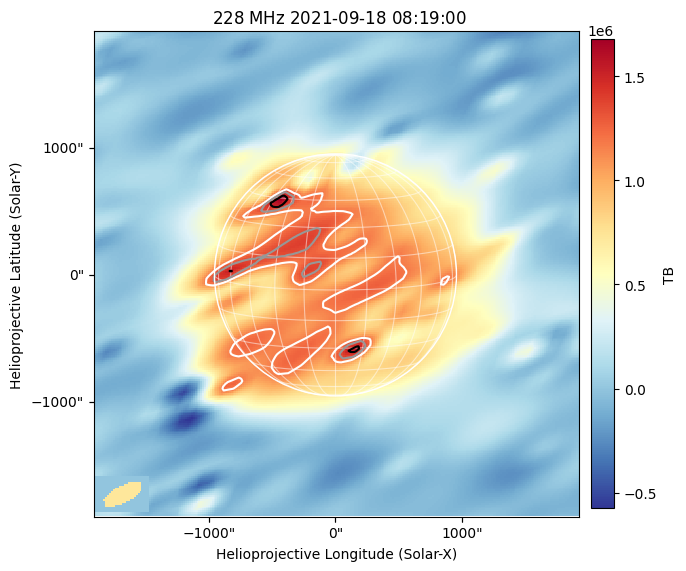

In [143]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, cmap='RdYlBu_r') # viridis, plasma, inferno, jet, hsv_r, RdYlBu_r
nrh_map.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
nrh_map.draw_limb(color='w')
nrh_map.draw_grid(color='w')
ax.grid(False)
fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
fig.tight_layout()
plt.show()

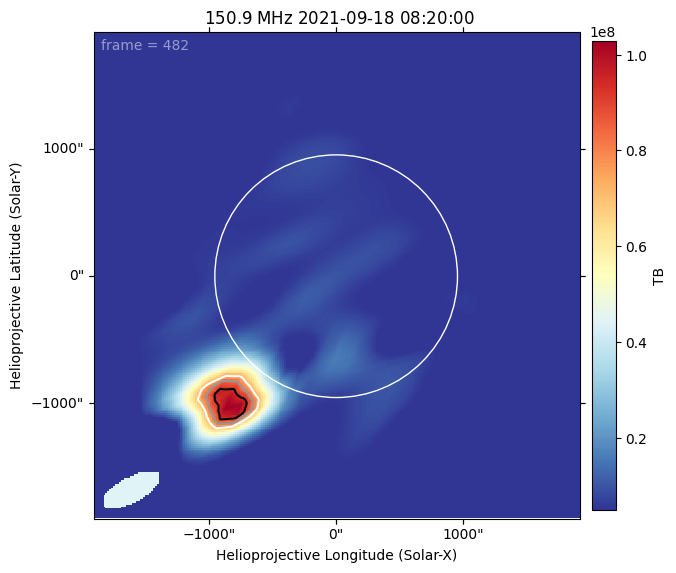

In [110]:
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=nrh_map)
img = nrh_map.plot(axes=ax, vmin=0.5e7, cmap='RdYlBu_r')
nrh_map.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
nrh_map.draw_limb(color='w')
ax.grid(False)
ax.text(3, nrh_map.data.shape[1]-10, f'frame = {image_index}', color='white', fontsize=10, alpha=0.5)
fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
fig.tight_layout()
plt.show()

In [ ]:
# Load AIA map
start_time = pd.Timestamp(nrh_map.meta['date-obs'])
end_time   = pd.Timestamp(nrh_map.meta['date-obs']) + timedelta(minutes=1)

aia_map = myfuncs.load_aia_single(data_dir=data_dir, start=start_time, end=end_time, level=1, channel=193)[0]

In [ ]:
# Plot radio contours on AIA data
fig = plt.figure(figsize=[10,7])
ax = fig.add_subplot(121, projection=aia_map)
aia_map.plot(axes=ax)
ax.grid(False)

ax = fig.add_subplot(122, projection=aia_map)
aia_map.plot_settings['norm'] = ImageNormalize(vmin=0, vmax=4e3, stretch=SqrtStretch())
aia_map.plot(axes=ax, cmap='Greys')
ax.grid(False)

fig.tight_layout()
plt.show()

In [112]:
with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
    nrh_map2 = nrh_map.reproject_to(aia_map.wcs)

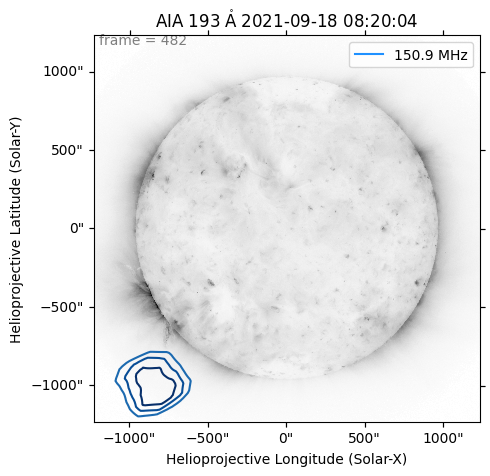

In [113]:
fig = plt.figure(figsize=[5,5])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Blues')
ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

# Make a proxy artist for the legend
contour_legend = mlines.Line2D([], [], color='dodgerblue', label=f"{nrh_map.meta['wavelnth']} MHz")
ax.legend(handles=[contour_legend])
ax.grid(False)
fig.tight_layout()
plt.show()

In [87]:
import matplotlib.cm as cm

# Define the colormaps you want to use
# colormaps = ['Greys', 'Purples', 'Blues', 'Greens', 'Oranges', 'Reds', 'YlGnBu']
colormaps = ['YlGnBu', 'Reds', 'Oranges', 'Greens', 'Blues', 'Purples', 'Greys']

# Choose a value to sample from the colormap (0.5 is the middle)
sample_value = 0.5

# Create a dictionary to store the selected colors
selected_colors = {}

for cmap_name in colormaps:
    cmap = cm.get_cmap(cmap_name)   # Get the colormap object
    color = cmap(sample_value)      # Sample the color at the middle point
    selected_colors[cmap_name] = color

# # Display the selected colors
# for cmap_name, color in selected_colors.items():
#     print(f"{cmap_name}: {color}")

YlGnBu: (0.2526874279123414, 0.7114494425221068, 0.7683813917723953, 1.0)
Reds: (0.9835755478662053, 0.4127950788158401, 0.28835063437139563, 1.0)
Oranges: (0.9914186851211073, 0.550726643598616, 0.23277201076509035, 1.0)
Greens: (0.45176470588235296, 0.7670895809304115, 0.4612072279892349, 1.0)
Blues: (0.41708573625528644, 0.6806305267204922, 0.8382314494425221, 1.0)
Purples: (0.617762399077278, 0.6021376393694733, 0.7834525182622069, 1.0)
Greys: (0.586082276047674, 0.586082276047674, 0.586082276047674, 1.0)


Loading NRH maps ...: 100%|███████████████████████████████████| 7/7 [15:34<00:00, 133.55s/it]


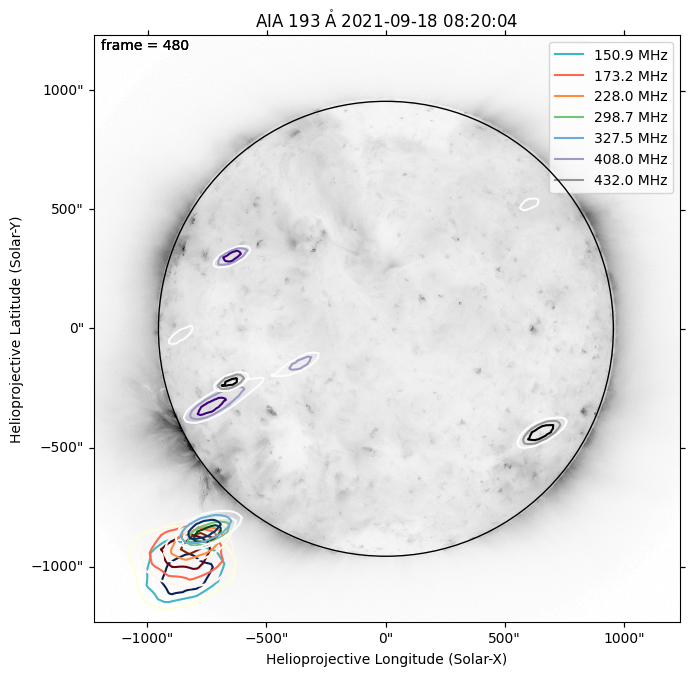

In [96]:
# Plot the contours of all frequencies of NRH on AIA map
fig = plt.figure(figsize=[7,7])
ax = fig.add_subplot(111, projection=aia_map)
aia_map.plot(axes=ax, cmap='Greys')
ax.text(50, aia_map.data.shape[1]-100, f'frame = {image_index}', color='black', fontsize=10, alpha=0.5)

handles = []

# Read NRH data
with tqdm(total=len(sav_files), desc='Loading NRH maps ...') as pbar:
    for i, filename in enumerate(sav_files):
        nrh = readsav(filename, python_dict=True)
        # add 240 == 1 second
        image_index = 0 + 240
        
        # getting header info for a given time index
        b = {name:nrh['nrh_hdr'][name][image_index] for name in nrh['nrh_hdr'].dtype.names}
        
        # Constuct the NRH image
        map_data = nrh['nrh_data'][image_index]
        
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                             frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                             )
        header = sunpy.map.make_fitswcs_header(map_data,
                                               ref_coord,
                                               reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                               scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                               wavelength=float(b['FREQ'])*u.MHz)
        nrh_map = sunpy.map.Map(map_data, header)
        
        with frames.Helioprojective.assume_spherical_screen(aia_map.observer_coordinate):
            nrh_map2 = nrh_map.reproject_to(aia_map.wcs)
        
        nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap=colormaps[i])
        
        # Make a proxy artist for the legend
        contour_legend = mlines.Line2D([], [], color=selected_colors[colormaps[i]], label=f"{nrh_map.meta['wavelnth']} MHz")
        handles.append(contour_legend)
        pbar.update(1)

# aia_map.draw_limb(color='k')
ax.grid(False)
ax.legend(handles=handles)
fig.tight_layout()
plt.show()

In [85]:
len(sav_files)



7

In [83]:
# fig = plt.figure(figsize=[7,7])
# ax = fig.add_subplot(111, projection=aia_map)
# aia_map.plot(axes=ax, cmap='Greys')
# c0 = nrh_map2.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Blues')

# # # calc the centroid as the geometry mean of the contour shape, center of mass
# # points0 = c0.allsegs[0][0]
# # centroid0 = points0.mean(axis=0)

# # # convert to arcsec unit
# # c_Arcsec = aia_map.pixel_to_world(centroid0[0]*u.pix, centroid0[1]*u.pix)
# # ax.plot_coord(c_Arcsec, color='r', marker='o', markersize=5, label=f"{nrh_map.meta['wavelnth']} MHz")

# # ax.legend(title='Centroids', loc='upper right')
# ax.legend(loc='upper right')
# ax.grid(False)
# fig.tight_layout()
# plt.show()

In [84]:
# aia_map.plot_settings['norm'] = colors.Normalize(vmin=0, vmax=350)

In [4]:
# print(len(nrh['nrh_data']))

In [5]:
# nrh['nrh_hdr'][0:len(nrh['nrh_data']):4]['DATE_OBS']

In [6]:
# len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4]['DATE_OBS'])

In [99]:
np.arange(70, 100, 10)

array([70, 80, 90])

In [134]:
# Calculate the number of rows
n = len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4])
images_per_row = 4
rows = int(np.ceil(n / images_per_row))

print(n, rows)

721 181


In [ ]:
fig = plt.figure(figsize=[18,5*rows])

# one image every one second
for i in range(len(nrh['nrh_hdr'][0:len(nrh['nrh_data']):4])):
    ax = plt.subplot(rows, images_per_row, i+1, projection=nrh_map)
    
    # get header info for a given time index
    b = {name:nrh['nrh_hdr'][name][i] for name in nrh['nrh_hdr'].dtype.names}
    
    # Constuct the NRH image
    map_data = nrh['nrh_data'][i]
    
    ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                         frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                         )
    header = sunpy.map.make_fitswcs_header(map_data,
                                           ref_coord,
                                           reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                           scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                           wavelength=float(b['FREQ'])*u.MHz)
    nrh_map = sunpy.map.Map(map_data, header)
    
    # Show the map
    img = nrh_map.plot(axes=ax, cmap='RdYlBu_r') # viridis, plasma, inferno, jet, hsv_r, RdYlBu_r
    nrh_map.draw_limb(color='w')
    ax.grid(False)
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8')) # Decode bytes to string using UTF-8 encoding
    
fig.tight_layout()
plt.show()

### Export PNG images

In [46]:
nrh_maps = []
# headers_list = []
# images_list  = []

with tqdm(total=len(nrh['nrh_hdr']), desc='Loading NRH maps ...') as pbar:
    for i in range(len(nrh['nrh_hdr'])):
        b = {name:nrh['nrh_hdr'][name][i] for name in nrh['nrh_hdr'].dtype.names}
        m = nrh['nrh_data'][i]
        # headers_list.append(b)
        # images_list.append(m)
        ref_coord = SkyCoord(0*u.arcsec, 0*u.arcsec, 
                    frame=frames.Helioprojective(observer='earth', obstime=b['DATE_OBS'])
                    )
        header = sunpy.map.make_fitswcs_header(m,
                                               ref_coord,
                                               reference_pixel=[int(b['CRPIX1'])-1, int(b['CRPIX2'])-1]*u.pixel,
                                               scale=[float(b['CDELT1']), float(b['CDELT2'])]*u.arcsec/u.pixel,
                                               wavelength=float(b['FREQ'])*u.MHz)
        nrh_map = sunpy.map.Map(m, header)
        nrh_maps.append(nrh_map)
        pbar.update(1)

os.makedirs(f"{savedir}/png/nrh/{nrh_map.meta['wavelnth']}MHz", exist_ok=True)

Loading NRH maps ...: 100%|██████████████████████████████| 2881/2881 [01:11<00:00, 40.40it/s]


In [47]:
with tqdm(total=len(nrh_maps), desc='Exporting NRH images ...') as pbar:
    for i, m in enumerate(nrh_maps):
        output_filename = f"{savedir}/png/nrh/{m.meta['wavelnth']}MHz/{m.meta['date-obs']}_{m.meta['wavelnth']}{m.meta['waveunit']}.png"
        if not os.path.exists(output_filename):
            fig = plt.figure(figsize=[7,7])
            ax = fig.add_subplot(111, projection=m)
            img = m.plot(axes=ax,
                         # vmin=0.5e7,
                         vmin=0.5e6,
                         cmap='RdYlBu_r')
            m.draw_contours(axes=ax, levels=np.arange(70, 100, 10)*u.percent, cmap='Greys')
            m.draw_limb(color='w')
            ax.grid(False)
            ax.text(3, nrh_map.data.shape[1]-10, f'frame = {i}', color='white', fontsize=10, alpha=0.5)
            ax.set_title(f"{m.meta['wavelnth']} {m.meta['waveunit']} {m.meta['date-obs'].replace('T',' ')}")
            fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
            fig.tight_layout()
            fig.savefig(output_filename, dpi=100, bbox_inches='tight')
            plt.close()
            pbar.update(1)

Exporting NRH images ...: 100%|████████████████████████| 2881/2881 [1:00:04<00:00,  1.25s/it]


## Persistant Imaging

In [ ]:
def normalize_2d(matrix):
    norm = np.linalg.norm(matrix)
    matrix = matrix/norm  # normalized matrix
    return matrix


import sunpy.io.fits as sfits


list_of_genericMaps = []
not_taken_bursts = []

for burst in filtered_lof_imgs_sorted:
    outmaps = []
    for ii, file in enumerate(burst):
        burst_num = int(re.search(r'burst_(\d+)', burst[0]).group(1))
        # ignore this image for burst 1 --> 13191
        #if burst_num == 1:
        #    print(file)
        map = get_lofar_map(file)
        map = sunpy.map.Map(normalize_2d(map.data), map.meta)
        if ii == 0:
            prevmap = map
            continue
        
        # in case the shapes didn't match
        if map.data.shape != prevmap.data.shape:
            #prevmap = sunpy.map.Map(prevmap.data, prevmap.meta)
            prevmap = sunpy.map.Map(normalize_2d(prevmap.data), prevmap.meta)
            prevmap.meta['bunit'] = 'Jy / pix'
            dimensions = u.Quantity([map.dimensions.x, map.dimensions.y])
            prevmap = prevmap.resample(dimensions)
        
        condition = np.greater(map.data, prevmap.data)
        arr = prevmap.data.copy()
        arr[condition] = map.data[condition]
        newmap = sunpy.map.Map(arr, map.meta)
        outmaps.append(newmap)
        prevmap = newmap

    # make a folder for each burst
    if burst_num < 10 and burst_num > 0:
        burst_folder = f'burst_0{burst_num}'
    else:
        burst_folder = f'burst_{burst_num}'
    
    try:
        os.mkdir(f'{mydir}/exported_pngs/persistent_pngs/{burst_folder}')
    except:
        pass
    
    # export png images
    for ii, outmap in enumerate(outmaps):
        savename = f"{mydir}/exported_pngs/persistent_pngs/{burst_folder}/{outmap._date_obs}_persistence.png"
        plt.figure(figsize=(6,6))
        outmap.plot(cmap='inferno')
        outmap.draw_limb()
        plt.title('')
        plt.savefig(savename, bbox_inches='tight')
        plt.close()
    
    ## export the last persistence map
    # Open the FITS file
    with fits.open(file) as hdul:
        # Extract the header
        header = hdul[0].header
    
    if len(outmaps) == 0:
        print(f'No enough files for burst {burst_num}')
        list_of_genericMaps.append([])
        not_taken_bursts.append(burst_num)
    else:
        map_obj = outmaps[-1]
        sfits.write(f'{mydir}/exported_pngs/persistent_pngs/persistence_{burst_folder}.fits', map_obj.data, header, overwrite=True)
        print(f'Burst {burst_num} is finished')

        # store the maps
        list_of_genericMaps.append(outmaps)

In [35]:
nrh.keys()

dict_keys(['nrh_data', 'nrh_hdr'])

In [37]:
nrh['nrh_hdr']['DATE_OBS'], nrh['nrh_hdr']['DATE_OBS'].shape

(array([b'2021-09-18T08:18:00.220Z', b'2021-09-18T08:18:00.470Z',
        b'2021-09-18T08:18:00.720Z', ..., b'2021-09-18T08:29:59.710Z',
        b'2021-09-18T08:29:59.960Z', b'2021-09-18T08:30:00.210Z'],
       dtype=object),
 (2881,))

In [38]:
nrh['nrh_hdr']['DATE_OBS'][1], nrh['nrh_hdr']['DATE_OBS'][0]

(b'2021-09-18T08:18:00.470Z', b'2021-09-18T08:18:00.220Z')

In [39]:
nrh['nrh_data'].shape

(2881, 256, 256)

In [41]:
nrh_map.meta

MetaDict([('wcsaxes': '2')
('crpix1': '128.0')
('crpix2': '128.0')
('cdelt1': '14.953816413879395')
('cdelt2': '14.953816413879395')
('cunit1': 'arcsec')
('cunit2': 'arcsec')
('ctype1': 'HPLN-TAN')
('ctype2': 'HPLT-TAN')
('crval1': '0.0')
('crval2': '0.0')
('lonpole': '180.0')
('latpole': '0.0')
('mjdref': '0.0')
('date-obs': '2021-09-18T08:18:00.220')
('rsun_ref': '695700000.0')
('dsun_obs': '150313987017.45')
('hgln_obs': '0.0')
('hglt_obs': '7.150155320291')
('wavelnth': '327.5')
('waveunit': 'MHz')
('naxis': '2')
('naxis1': '256')
('naxis2': '256')
('pc1_1': '1.0')
('pc1_2': '-0.0')
('pc2_1': '0.0')
('pc2_2': '1.0')
('rsun_obs': '954.6612452914233')])

In [11]:
# for name in nrh['nrh_hdr'].dtype.names:
#     print(name, nrh['nrh_hdr'][name][0])

Plot all images and make animation

In [ ]:
fig = plt.figure(figsize=[20,20])

for i, nrh_map in enumerate(nrh_maps[:25]):
    ax = fig.add_subplot(5,5,i+1, projection=nrh_map)
    img = nrh_map.plot(axes=ax, cmap='viridis')
    nrh_map.draw_limb(color='w')
    nrh_map.draw_grid(color='w')
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))

fig.tight_layout()
plt.show()

Export each image individually

In [16]:
pathdir = r'D:\Study\Academic\Research\PostDoc_work\DIAS_Fellowship_2024\Work\plots\nrh'
# 
for i, nrh_map in enumerate(nrh_maps[1253:]):
    fig = plt.figure(figsize=[7,7])
    ax = fig.add_subplot(111, projection=nrh_map)
    img = nrh_map.plot(axes=ax, cmap='jet')
    nrh_map.draw_limb(color='w')
    nrh_map.draw_grid(color='w')
    fig.colorbar(img, pad=0.02, shrink=0.75, label=b['BUNIT'].decode('utf-8'))
    fig.tight_layout()
    fig.savefig(f"{pathdir}/{nrh_map.meta['wavelnth']}_{nrh_map.meta['waveunit']}_{nrh_map.meta['date-obs'].replace(':','_')}.png",
                format='png', dpi=100, bbox_inches='tight')
    plt.close()
    print(f"{nrh_map.meta['date-obs']} has been exported.")

2021-09-18T08:23:13.450 has been exported.
2021-09-18T08:23:13.700 has been exported.
2021-09-18T08:23:13.950 has been exported.
2021-09-18T08:23:14.200 has been exported.
2021-09-18T08:23:14.450 has been exported.
2021-09-18T08:23:14.700 has been exported.
2021-09-18T08:23:14.950 has been exported.
2021-09-18T08:23:15.200 has been exported.
2021-09-18T08:23:15.450 has been exported.
2021-09-18T08:23:15.700 has been exported.
2021-09-18T08:23:15.950 has been exported.
2021-09-18T08:23:16.200 has been exported.
2021-09-18T08:23:16.450 has been exported.
2021-09-18T08:23:16.700 has been exported.
2021-09-18T08:23:16.950 has been exported.
2021-09-18T08:23:17.200 has been exported.
2021-09-18T08:23:17.450 has been exported.
2021-09-18T08:23:17.700 has been exported.
2021-09-18T08:23:17.950 has been exported.
2021-09-18T08:23:18.200 has been exported.
2021-09-18T08:23:18.450 has been exported.
2021-09-18T08:23:18.700 has been exported.
2021-09-18T08:23:18.950 has been exported.
2021-09-18T

KeyboardInterrupt: 